## Problem Statement: 
Given a set of attributes for an Individual, determine if a credit line should be extended to them. The main challenge is to minimise the risk of NPAs by flagging defaulters while maximising opportunity to earn interest by disbursing loans to as many customers as possible.

## Importing Libraries

In [1]:
# pip install imbalanced-learn

In [2]:
#Data processing
import pandas as pd
import numpy as np

#Data Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#Seting option for full column view of Data
pd.set_option('display.max_columns', None)

#Stats & model building
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_curve, auc, ConfusionMatrixDisplay,
                             f1_score, recall_score,
                             precision_score, precision_recall_curve,
                             average_precision_score, classification_report)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

#Hide warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('LoanTapData.csv')
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [4]:
#shape of data
df.shape

(396030, 27)

In [5]:
# Statistical summary
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [6]:
df.describe(include='all')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
count,396030.000000,396030,396030.000000,396030.000000,396030,396030,373103,377729,396030,3.960300e+05,396030,396030,396030,396030,394275,396030.000000,396030,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,396030,396030,358235.000000,395495.000000,396030
unique,NaN,2,NaN,NaN,7,35,173105,11,6,NaN,3,115,2,14,48817,NaN,684,NaN,NaN,NaN,NaN,NaN,2,3,NaN,NaN,393700
top,NaN,36 months,NaN,NaN,B,B3,Teacher,10+ years,MORTGAGE,NaN,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,NaN,Oct-2000,NaN,NaN,NaN,NaN,NaN,f,INDIVIDUAL,NaN,NaN,USCGC Smith\r\nFPO AE 70466
freq,NaN,302005,NaN,NaN,116018,26655,4389,126041,198348,NaN,139563,14846,318357,234507,152472,NaN,3017,NaN,NaN,NaN,NaN,NaN,238066,395319,NaN,NaN,8
mean,14113.888089,NaN,13.639400,431.849698,NaN,NaN,NaN,NaN,NaN,7.420318e+04,NaN,NaN,NaN,NaN,NaN,17.379514,NaN,11.311153,0.178191,1.584454e+04,53.791749,25.414744,NaN,NaN,1.813991,0.121648,NaN
std,8357.441341,NaN,4.472157,250.727790,NaN,NaN,NaN,NaN,NaN,6.163762e+04,NaN,NaN,NaN,NaN,NaN,18.019092,NaN,5.137649,0.530671,2.059184e+04,24.452193,11.886991,NaN,NaN,2.147930,0.356174,NaN
min,500.000000,NaN,5.320000,16.080000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000,2.000000,NaN,NaN,0.000000,0.000000,NaN
25%,8000.000000,NaN,10.490000,250.330000,NaN,NaN,NaN,NaN,NaN,4.500000e+04,NaN,NaN,NaN,NaN,NaN,11.280000,NaN,8.000000,0.000000,6.025000e+03,35.800000,17.000000,NaN,NaN,0.000000,0.000000,NaN
50%,12000.000000,NaN,13.330000,375.430000,NaN,NaN,NaN,NaN,NaN,6.400000e+04,NaN,NaN,NaN,NaN,NaN,16.910000,NaN,10.000000,0.000000,1.118100e+04,54.800000,24.000000,NaN,NaN,1.000000,0.000000,NaN
75%,20000.000000,NaN,16.490000,567.300000,NaN,NaN,NaN,NaN,NaN,9.000000e+04,NaN,NaN,NaN,NaN,NaN,22.980000,NaN,14.000000,0.000000,1.962000e+04,72.900000,32.000000,NaN,NaN,3.000000,0.000000,NaN


## Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

### Checking Column Datatypes

In [8]:
# Non-numeric columns
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [9]:
# Number of unique values in all non-numeric columns
for col in cat_cols:
  print(f"No. of unique values in {col}: {df[col].nunique()}")

No. of unique values in term: 2
No. of unique values in grade: 7
No. of unique values in sub_grade: 35
No. of unique values in emp_title: 173105
No. of unique values in emp_length: 11
No. of unique values in home_ownership: 6
No. of unique values in verification_status: 3
No. of unique values in issue_d: 115
No. of unique values in loan_status: 2
No. of unique values in purpose: 14
No. of unique values in title: 48817
No. of unique values in earliest_cr_line: 684
No. of unique values in initial_list_status: 2
No. of unique values in application_type: 3
No. of unique values in address: 393700


In [10]:
# Convert earliest credit line & issue date to datetime
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [11]:
#Convert employment length to numeric
d = {'10+ years':10, '4 years':4, '< 1 year':0,
     '6 years':6, '9 years':9,'2 years':2, '3 years':3,
     '8 years':8, '7 years':7, '5 years':5, '1 year':1}
df['emp_length']=df['emp_length'].replace(d)

In [12]:
#Convert columns with less number of unique values to categorical columns
cat_cols = ['term', 'grade','sub_grade','home_ownership',
            'verification_status','loan_status','purpose',
            'initial_list_status','application_type']

df[cat_cols] = df[cat_cols].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  category      
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  category      
 5   sub_grade             396030 non-null  category      
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  float64       
 8   home_ownership        396030 non-null  category      
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  category      
 11  issue_d               396030 non-null  datetime64[ns]
 12  loan_status           396030 non-null  category      
 13 

### Check for Duplicate Values

In [14]:
df.duplicated().sum()

0

There are no duplicate instances in the data

### Handling Missing Values

In [15]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [16]:
#Filling missing values with 'Unknown' for object dtype
fill_values = {'title': 'Unknown', 'emp_title': 'Unknown'}
df.fillna(value=fill_values, inplace=True)

In [17]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title                   0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                       0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [18]:
#Mean aggregation of mort_acc by total_acc to fill missing values

avg_mort = df.groupby('total_acc')['mort_acc'].mean()

def fill_mort(total_acc, mort_acc):
  if np.isnan(mort_acc):
    return avg_mort[total_acc].round()
  else:
    return mort_acc

In [19]:
df['mort_acc'] = df.apply(lambda x: fill_mort(x['total_acc'],x['mort_acc']), axis=1)

In [20]:
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10.0,RENT,117000.0,Not Verified,2015-01-01,Fully Paid,vacation,Vacation,26.24,1990-06-01,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4.0,MORTGAGE,65000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,Debt consolidation,22.05,2004-07-01,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,0.0,RENT,43057.0,Source Verified,2015-01-01,Fully Paid,credit_card,Credit card refinancing,12.79,2007-08-01,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6.0,RENT,54000.0,Not Verified,2014-11-01,Fully Paid,credit_card,Credit card refinancing,2.60,2006-09-01,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9.0,MORTGAGE,55000.0,Verified,2013-04-01,Charged Off,credit_card,Credit Card Refinance,33.95,1999-03-01,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,60 months,10.99,217.38,B,B4,licensed bankere,2.0,RENT,40000.0,Source Verified,2015-10-01,Fully Paid,debt_consolidation,Debt consolidation,15.63,2004-11-01,6.0,0.0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0,"12951 Williams Crossing\r\nJohnnyville, DC 30723"
396026,21000.0,36 months,12.29,700.42,C,C1,Agent,5.0,MORTGAGE,110000.0,Source Verified,2015-02-01,Fully Paid,debt_consolidation,Debt consolidation,21.45,2006-02-01,6.0,0.0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0,"0114 Fowler Field Suite 028\r\nRachelborough, ..."
396027,5000.0,36 months,9.99,161.32,B,B1,City Carrier,10.0,RENT,56500.0,Verified,2013-10-01,Fully Paid,debt_consolidation,pay off credit cards,17.56,1997-03-01,15.0,0.0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0,"953 Matthew Points Suite 414\r\nReedfort, NY 7..."
396028,21000.0,60 months,15.31,503.02,C,C2,"Gracon Services, Inc",10.0,MORTGAGE,64000.0,Verified,2012-08-01,Fully Paid,debt_consolidation,Loanforpayoff,15.88,1990-11-01,9.0,0.0,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0,"7843 Blake Freeway Apt. 229\r\nNew Michael, FL..."


In [21]:
# Dropping rows with null values
df.dropna(inplace=True)

In [22]:
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
title                   0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64

In [23]:
df.shape

(376929, 27)

### Outlier Treatment

In [24]:
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

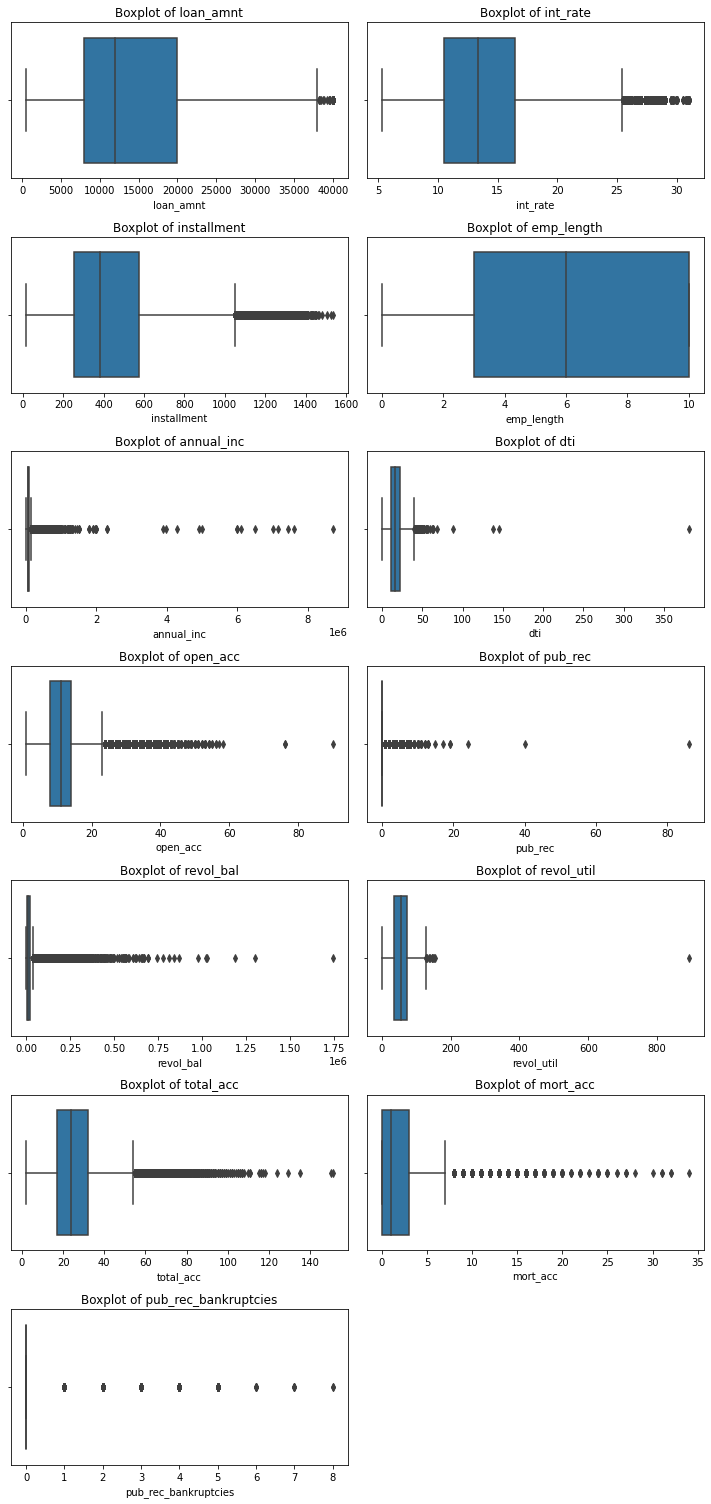

In [25]:
fig = plt.figure(figsize=(10,21))
i=1
for col in num_cols:
  ax = plt.subplot(7,2,i)
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
  i += 1

plt.tight_layout()
plt.show()

Here we can see that many columns have outliers.\
Lets remove the rows with outliers using standard deviation (99% data is within 3 standard deviations in case of normally distributed data).\
For pub_Rec and pub_rec_bankruptcies, we can apply the 0 or 1 approach

In [26]:
# Convert pub_rec and pub_rec_bankruptcies to categorical variables
df['pub_rec_bankruptcies'] = np.where(df['pub_rec_bankruptcies']>0,'yes','no')
df['pub_rec'] = np.where(df['pub_rec']>0,'yes','no')
df[['pub_rec_bankruptcies','pub_rec']] = df[['pub_rec_bankruptcies','pub_rec']].astype('category')

In [27]:
# Numeric columns after converting public records to category
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc'],
      dtype='object')

In [28]:
#Removing outliers using standard deviation
for col in num_cols:
  mean=df[col].mean()
  std=df[col].std()
  upper = mean + (3*std)
  df = df[~(df[col]>upper)]

In [29]:
df.shape

(350845, 27)

### Feature Engineering

In [30]:
df['address'].sample(10)

302167          997 White Underpass\r\nNew Jeremy, ID 22690
316703    670 Justin Islands Suite 818\r\nEast Matthewbo...
274564    25282 Castaneda Isle Apt. 988\r\nAllisonbury, ...
209231    7116 Bradford Forge Apt. 586\r\nSteelechester,...
183880               276 Hill Flat\r\nWest Sharon, MN 86630
389219            901 Jones Square\r\nEast Andrew, OR 00813
190894                   PSC 3107, Box 0888\r\nAPO AA 11650
272362    87059 Choi Road Suite 382\r\nDawsonmouth, MO 0...
215137          58358 Collins Mills\r\nValdezland, WA 00813
135235    58068 Julie Pass Suite 518\r\nSouth Manuel, TX...
Name: address, dtype: object

In [31]:
# Deriving zip code and state from address
df[['state', 'zip_code']] = df['address'].apply(lambda x: pd.Series([x[-8:-6], x[-5:]]))

In [32]:
#Drop address
df.drop(["address"], axis = 1, inplace=True)

In [33]:
df.zip_code.nunique()

10

Since there are only 10 zipcodes, we can change the datatype of zipcodes to categorical

In [34]:
df['zip_code'] = df['zip_code'].astype('category')

## Exploratory Data Analysis

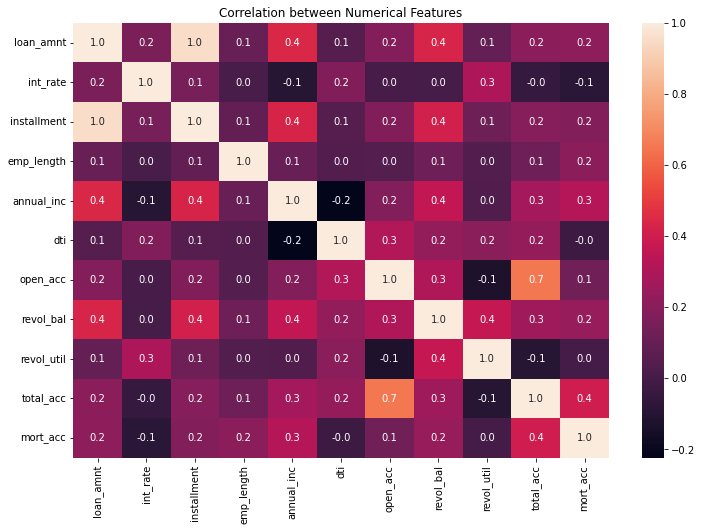

In [35]:
#Correlation between numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".1f")
plt.title('Correlation between Numerical Features')
plt.show()

1. loan_amnt and installment are perfectly correlated
2. total_acc is highly correlated with open_acc
4. total_acc is moderately correlated with mort_acc\
We can remove some of these correlated features to avoid multicolinearity

In [36]:
#Drop installment
df.drop(columns=['installment'], inplace=True)

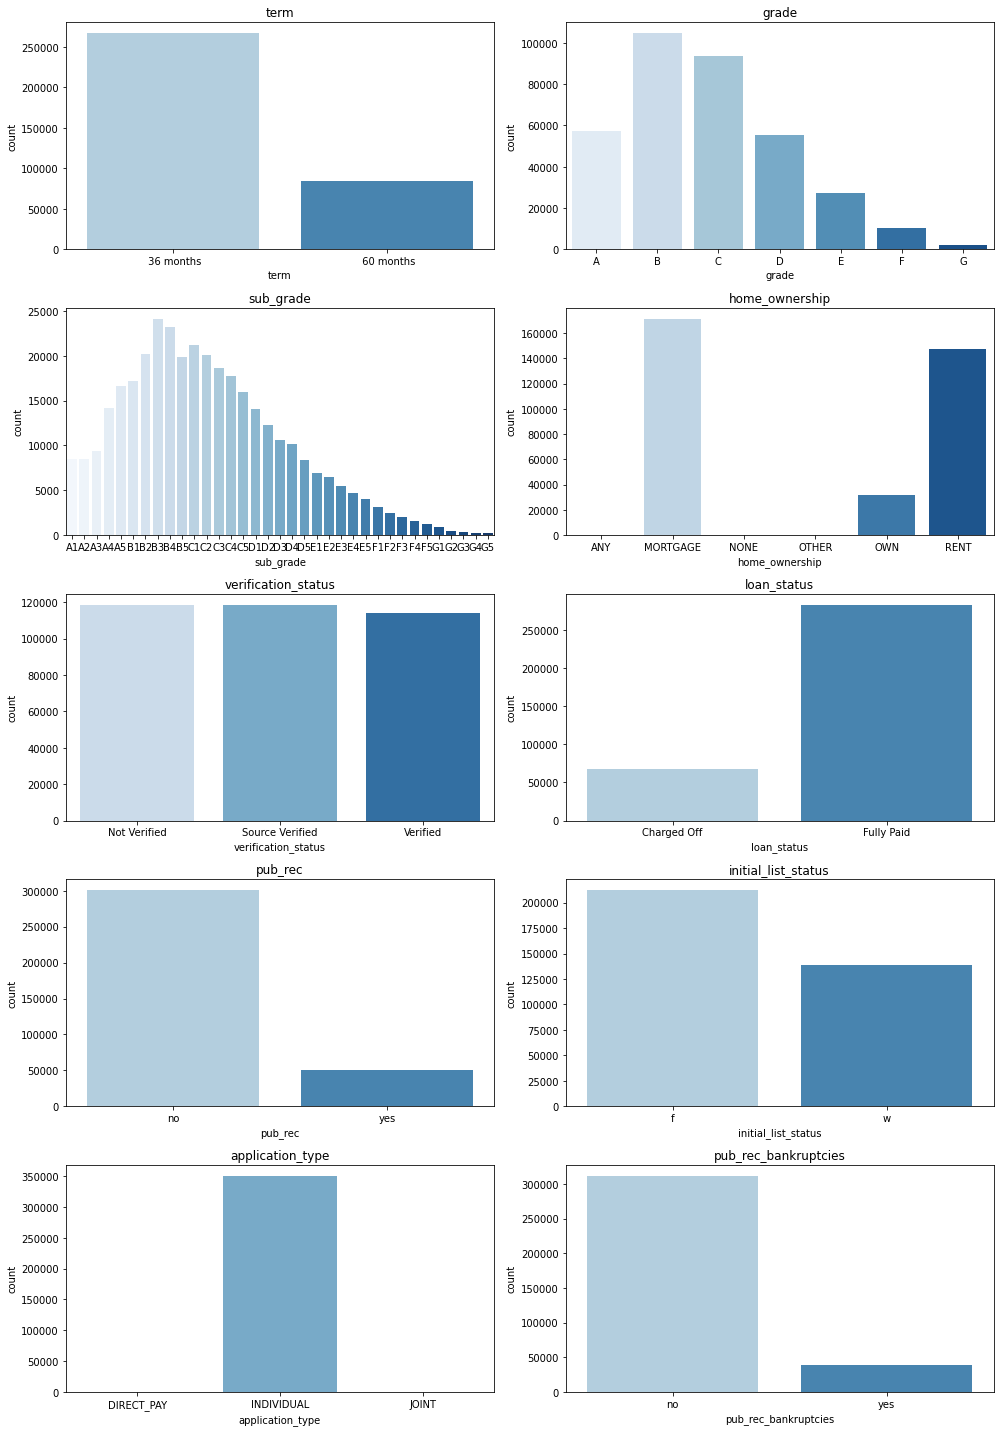

In [37]:
#Distribution of categorical variables
plot = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'loan_status', 'pub_rec', 'initial_list_status',
       'application_type', 'pub_rec_bankruptcies']

plt.figure(figsize=(14,20))
i=1
for col in plot:
  ax=plt.subplot(5,2,i)
  sns.countplot(x=df[col], palette='Blues')
  plt.title(f'{col}')
  i += 1

plt.tight_layout()
plt.show()

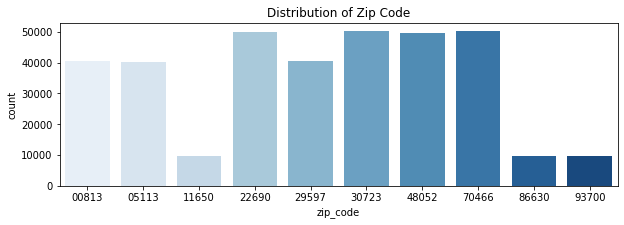

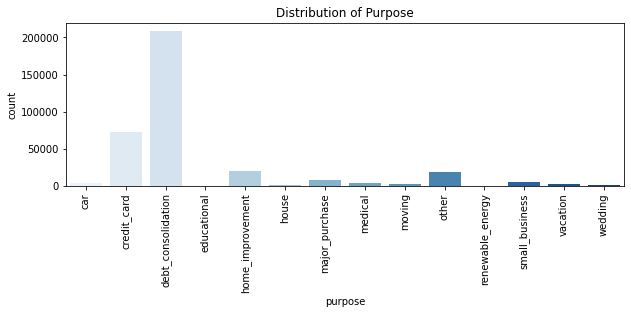

In [38]:
plt.figure(figsize=(10,3))
sns.countplot(x=df['zip_code'], palette='Blues')
plt.title('Distribution of Zip Code')

plt.figure(figsize=(10,3))
sns.countplot(x=df['purpose'], palette='Blues')
plt.xticks(rotation=90)
plt.title('Distribution of Purpose')

plt.show()

Observations:
* Almost 80% loans are of 36 months term
* Maximum loans (30%) fall in B grade, followed by C,A & D respectively
* The type of home ownership for 50% cases is mortgage
* The target variable (loan status) is imbalanced in the favour of fully-paid loans. Defaulters are approx 25% of fully paid instances.
* 85% of applicants don't have a public record/haven't filled for bankruptcy
* 99% applicants have applied under 'individual' application type
* 55% of loans are taken for the purpose of debt consolidation followed by 20% on credit card

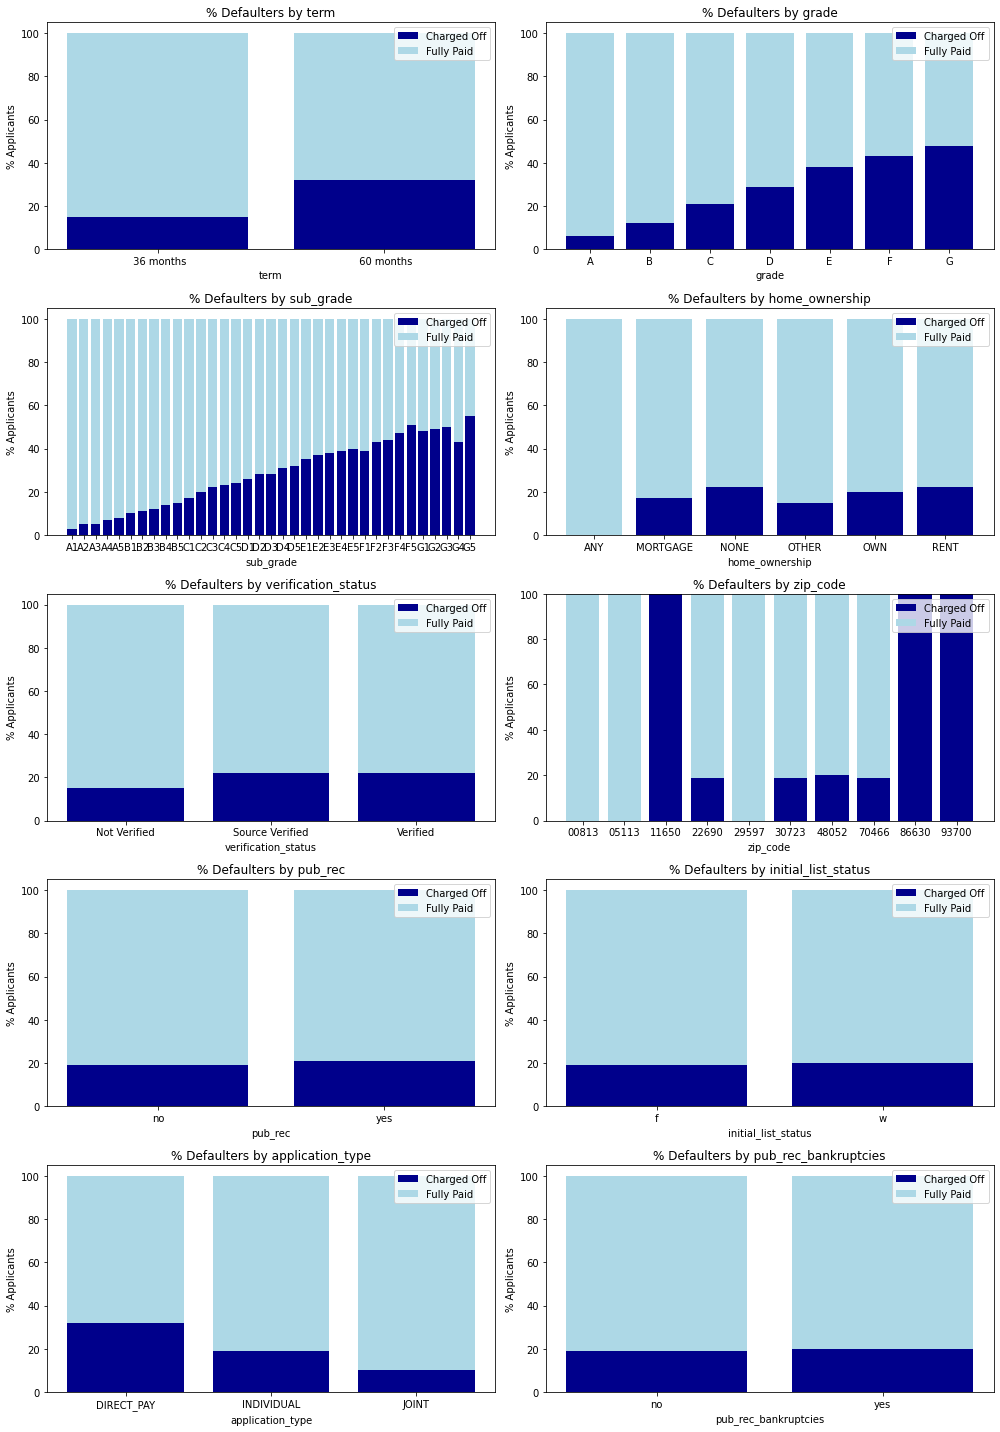

In [39]:
# Impact of categorical factors on loan status

plot = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'zip_code', 'pub_rec', 'initial_list_status',
       'application_type', 'pub_rec_bankruptcies']

plt.figure(figsize=(14,20))
i=1
for col in plot:
  ax=plt.subplot(5,2,i)

  data = df.pivot_table(index=col, columns='loan_status', aggfunc='count', values='purpose')
  data = data.div(data.sum(axis=1), axis=0).multiply(100).round()
  data.reset_index(inplace=True)

  plt.bar(data[col],data['Charged Off'], color='#00008b')
  plt.bar(data[col],data['Fully Paid'], color='#add8e6', bottom=data['Charged Off'])
  plt.xlabel(f'{col}')
  plt.ylabel('% Applicants')
  plt.title(f'% Defaulters by {col}')
  plt.legend(['Charged Off','Fully Paid'])
  i += 1

plt.tight_layout()
plt.show()

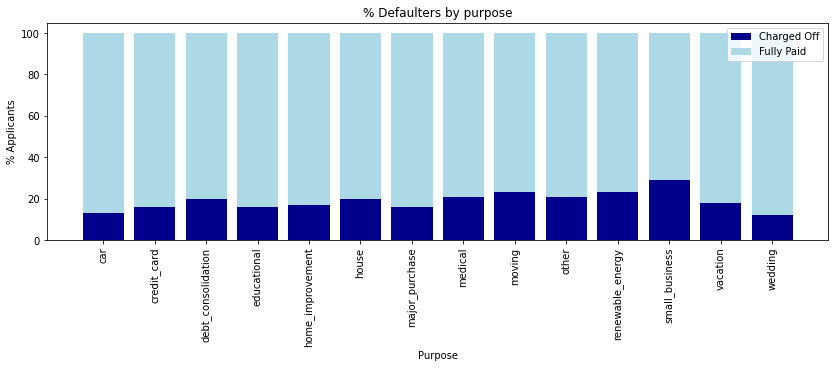

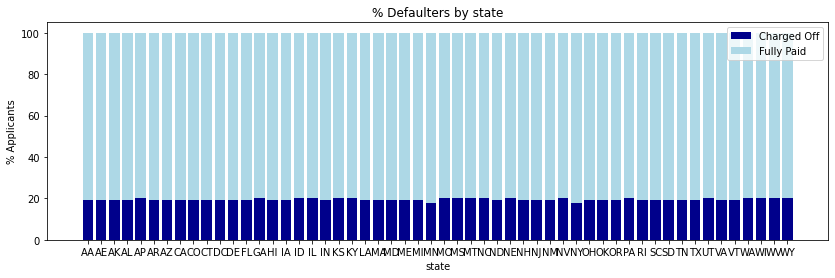

In [40]:
# Impact of Purpose/state on loan status

purpose = df.pivot_table(index='purpose', columns='loan_status', aggfunc='count', values='sub_grade')
purpose = purpose.div(purpose.sum(axis=1), axis=0).multiply(100).round()
purpose.reset_index(inplace=True)

plt.figure(figsize=(14,4))
plt.bar(purpose['purpose'],purpose['Charged Off'], color='#00008b')
plt.bar(purpose['purpose'],purpose['Fully Paid'], color='#add8e6', bottom=purpose['Charged Off'])
plt.xlabel('Purpose')
plt.ylabel('% Applicants')
plt.title('% Defaulters by purpose')
plt.legend(['Charged Off','Fully Paid'])
plt.xticks(rotation=90)
plt.show()

state = df.pivot_table(index='state', columns='loan_status', aggfunc='count', values='sub_grade')
state = state.div(state.sum(axis=1), axis=0).multiply(100).round()
state.reset_index(inplace=True)

plt.figure(figsize=(14,4))
plt.bar(state['state'],state['Charged Off'], color='#00008b')
plt.bar(state['state'],state['Fully Paid'], color='#add8e6', bottom=state['Charged Off'])
plt.xlabel('state')
plt.ylabel('% Applicants')
plt.title('% Defaulters by state')
plt.legend(['Charged Off','Fully Paid'])
plt.show()

Observations:
* The % of defaulters is much higher for longer (60-month) term
* As expected, grade/sub-grade has the maximum impact on loan_status with highest grade having maximum defaulters
* Zip codes such as 11650, 86630 and 93700 have 100% defaulters
* We can remove initial_list_status and state as they have no impact on loan_status
* public records also don't seem to have any impact on loan_status surprisingly
* Direct pay application type has higher default rate compared to individual/joint
* Loan taken for the purpose of small business has the highest rate of default

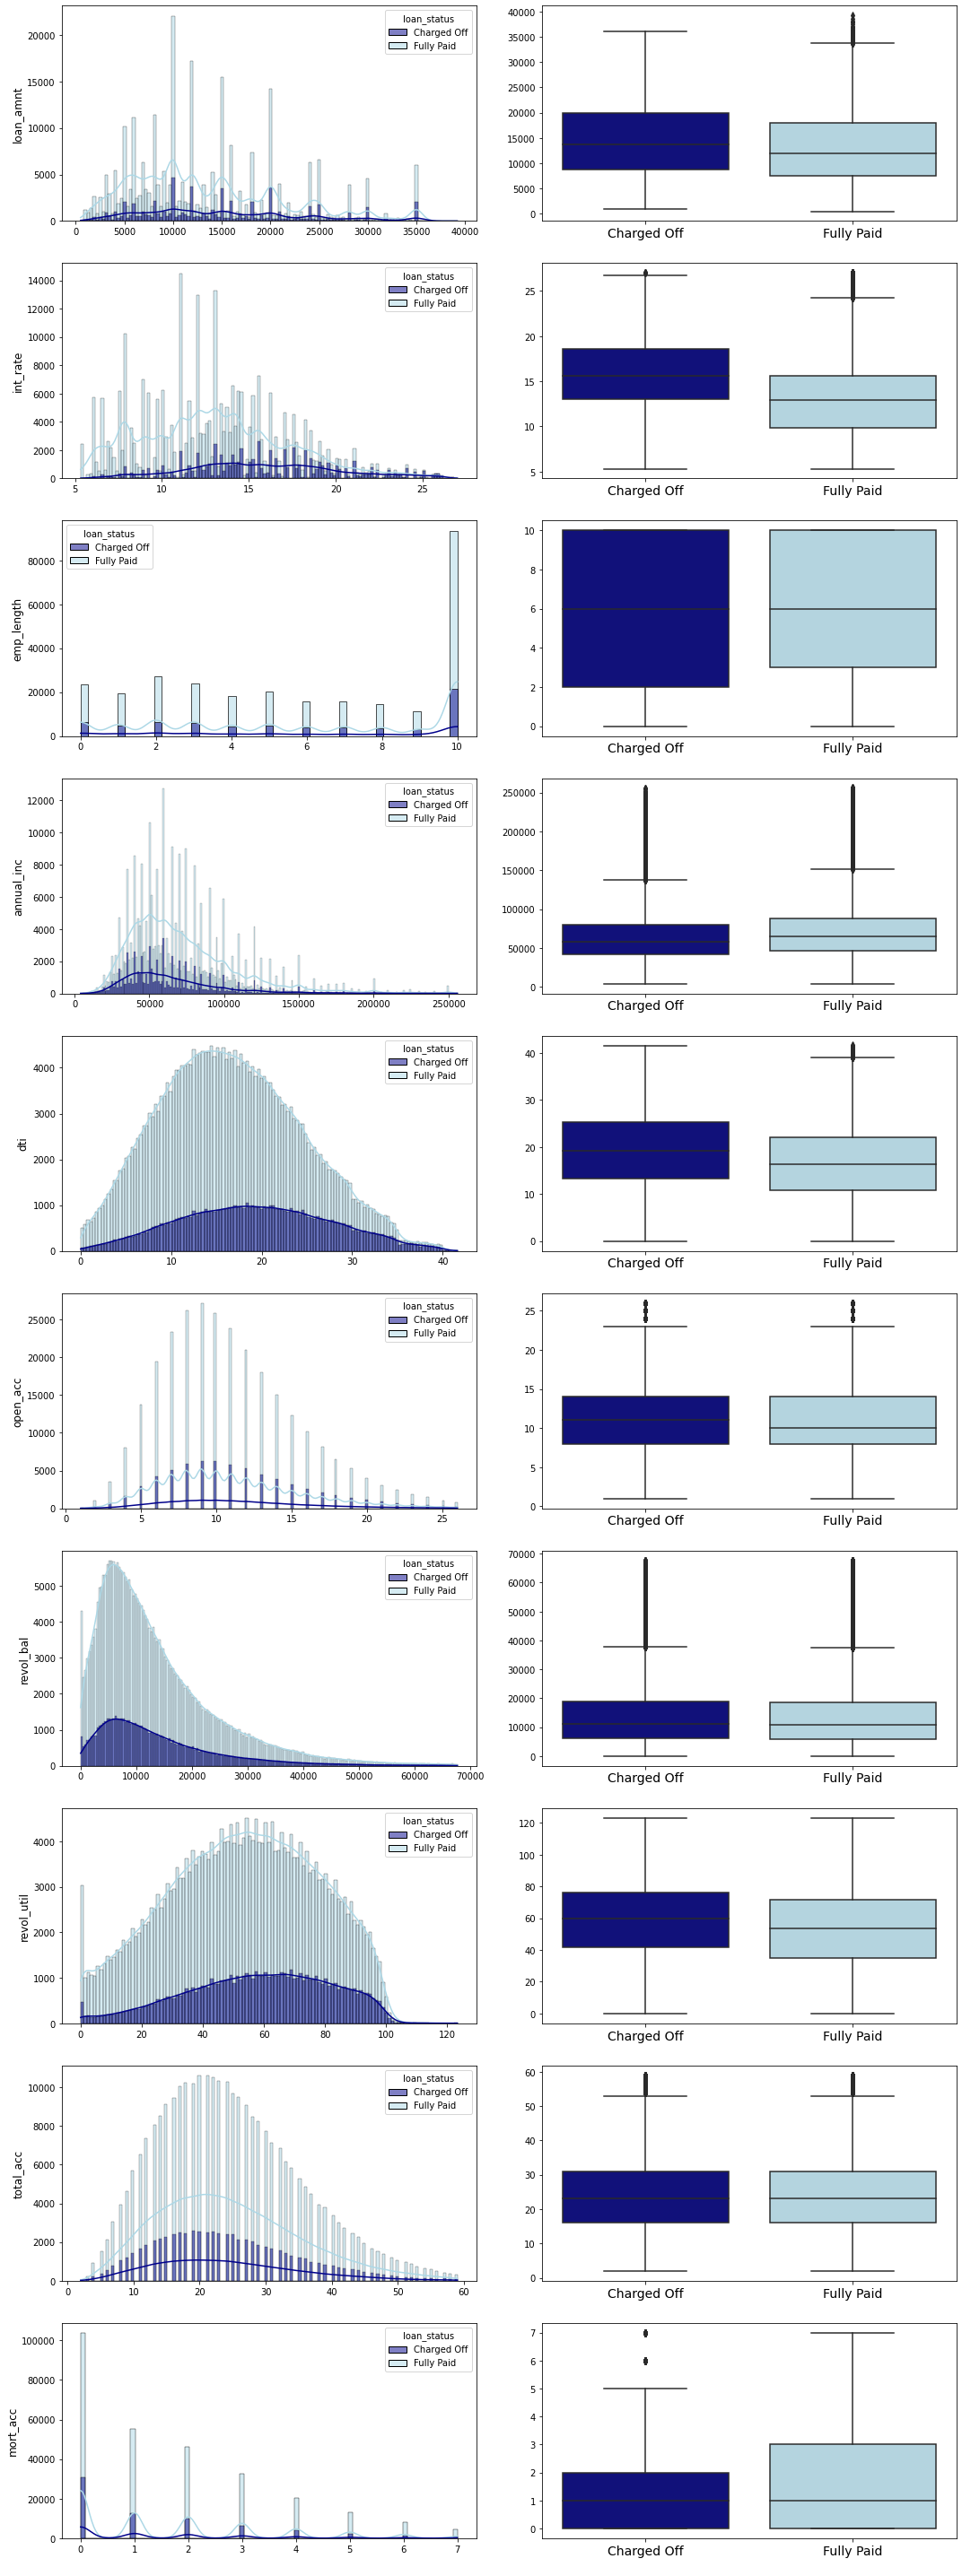

In [41]:
# Impact of numerical features on loan_status

num_cols = df.select_dtypes(include='number').columns

fig, ax = plt.subplots(10,2,figsize=(15,40))
i=0
color_dict = {'Fully Paid': matplotlib.colors.to_rgba('#add8e6', 0.5),
              'Charged Off': matplotlib.colors.to_rgba('#00008b', 1)}
for col in num_cols:
    sns.histplot(data=df, x=col, hue='loan_status', ax=ax[i, 0], legend=True,
                palette=color_dict, kde=True, fill=True)
    sns.boxplot(data=df, y=col, x='loan_status', ax=ax[i,1],
               palette=('#00008b', '#add8e6'))
    ax[i,0].set_ylabel(col, fontsize=12)
    ax[i,0].set_xlabel(' ')
    ax[i,1].set_xlabel(' ')
    ax[i,1].set_ylabel(' ')
    ax[i,1].xaxis.set_tick_params(labelsize=14)
    i += 1

plt.tight_layout()
plt.show()

Observations:  
* From the boxplots, it can be observed that the mean loan_amnt, int_rate, dti, open_acc and revol_util are slightly higher for defaulters while annual income is lower

In [42]:
# Remove columns which do not have an impact on loan_status
df.drop(columns=['initial_list_status','state',
                 'emp_title', 'title','earliest_cr_line',
                 'issue_d','sub_grade'], inplace=True)

# Subgrade is removed because grade and subgrade are similar features

## Data Pre-Processing

In [43]:
# Encoding Target Variable
df['loan_status']=df['loan_status'].map({'Fully Paid': 0, 'Charged Off':1}).astype(int)

In [44]:
x = df.drop(columns=['loan_status'])
x.reset_index(inplace=True, drop=True)
y = df['loan_status']
y.reset_index(drop=True, inplace=True)

In [45]:
# Encoding Binary features into numerical dtype
x['term']=x['term'].map({' 36 months': 36, ' 60 months':60}).astype(int)
x['pub_rec']=x['pub_rec'].map({'no': 0, 'yes':1}).astype(int)
x['pub_rec_bankruptcies']=x['pub_rec_bankruptcies'].map({'no': 0, 'yes':1}).astype(int)

### One Hot Encoding of Categorical Features

In [46]:
cat_cols = x.select_dtypes('category').columns

encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(x[cat_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols))
x = pd.concat([x,encoded_df], axis=1)
x.drop(columns=cat_cols, inplace=True)
x.head()

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_DIRECT_PAY,application_type_INDIVIDUAL,application_type_JOINT,zip_code_00813,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,10000.0,36,11.44,10.0,117000.0,26.24,16.0,0,36369.0,41.8,25.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8000.0,36,11.99,4.0,65000.0,22.05,17.0,0,20131.0,53.3,27.0,3.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15600.0,36,10.49,0.0,43057.0,12.79,13.0,0,11987.0,92.2,26.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7200.0,36,6.49,6.0,54000.0,2.60,6.0,0,5472.0,21.5,13.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24375.0,60,17.27,9.0,55000.0,33.95,13.0,0,24584.0,69.8,43.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test Split

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,stratify=y,random_state=42)

In [48]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((280676, 56), (280676,), (70169, 56), (70169,))

### Scaling Numeric Features

In [49]:
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [50]:
x_train.tail()

,loan_amnt,term,int_rate,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_DIRECT_PAY,application_type_INDIVIDUAL,application_type_JOINT,zip_code_00813,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
280671,0.167959,0.0,0.141671,0.7,0.194444,0.255954,0.60,0.0,0.104275,0.271695,0.578947,0.428571,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
280672,0.497416,0.0,0.445778,0.4,0.182540,0.414482,0.24,0.0,0.224536,0.670722,0.263158,0.285714,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280673,0.064599,0.0,0.686664,0.7,0.238095,0.220111,0.32,0.0,0.249454,0.622871,0.385965,0.428571,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
280674,0.245478,1.0,0.177665,0.9,0.313492,0.134953,0.92,0.0,0.080701,0.039740,0.842105,0.428571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280675,0.646641,1.0,0.885095,0.6,0.349206,0.747173,0.88,1.0,0.213775,0.543390,0.596491,0.714286,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Oversampling with SMOTE

In [51]:
# Oversampling to balance the target variable

sm=SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train,y_train.ravel())

print(f"Before OverSampling, count of label 1: {sum(y_train == 1)}")
print(f"Before OverSampling, count of label 0: {sum(y_train == 0)}")
print(f"After OverSampling, count of label 1: {sum(y_train_res == 1)}")
print(f"After OverSampling, count of label 0: {sum(y_train_res == 0)}")

Before OverSampling, count of label 1: 54200
Before OverSampling, count of label 0: 226476
After OverSampling, count of label 1: 226476
After OverSampling, count of label 0: 226476


## Logistic Regression

Train Accuracy : 0.8
Train F1 Score: 0.61
Train Recall Score: 0.81
Train Precision Score: 0.49

Test Accuracy : 0.8
Test F1 Score: 0.61
Test Recall Score: 0.81
Test Precision Score: 0.49


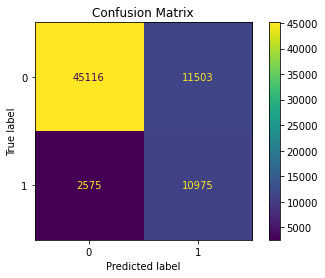

In [52]:
model = LogisticRegression()
model.fit(x_train_res, y_train_res)
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

#Model Evaluation
print('Train Accuracy :', model.score(x_train, y_train).round(2))
print('Train F1 Score:',f1_score(y_train,train_preds).round(2))
print('Train Recall Score:',recall_score(y_train,train_preds).round(2))
print('Train Precision Score:',precision_score(y_train,train_preds).round(2))

print('\nTest Accuracy :',model.score(x_test,y_test).round(2))
print('Test F1 Score:',f1_score(y_test,test_preds).round(2))
print('Test Recall Score:',recall_score(y_test,test_preds).round(2))
print('Test Precision Score:',precision_score(y_test,test_preds).round(2))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [53]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     56619
           1       0.49      0.81      0.61     13550

    accuracy                           0.80     70169
   macro avg       0.72      0.80      0.74     70169
weighted avg       0.86      0.80      0.82     70169



* It can be observed that the recall score is very high (our model is able to identify 80% of actual defaulters) but the precision is low for positive class (of all the predicted defaulters, only 50% are actually defaulters).
* Although this model is effective in reducing NPAs by flagging most of the defaulters, it may cause loantap to deny loans to many deserving customers due to low precision (false positives)
* Low precision has also caused F1 score to drop to 60% even though accuracy is 80%

### Feature Importance

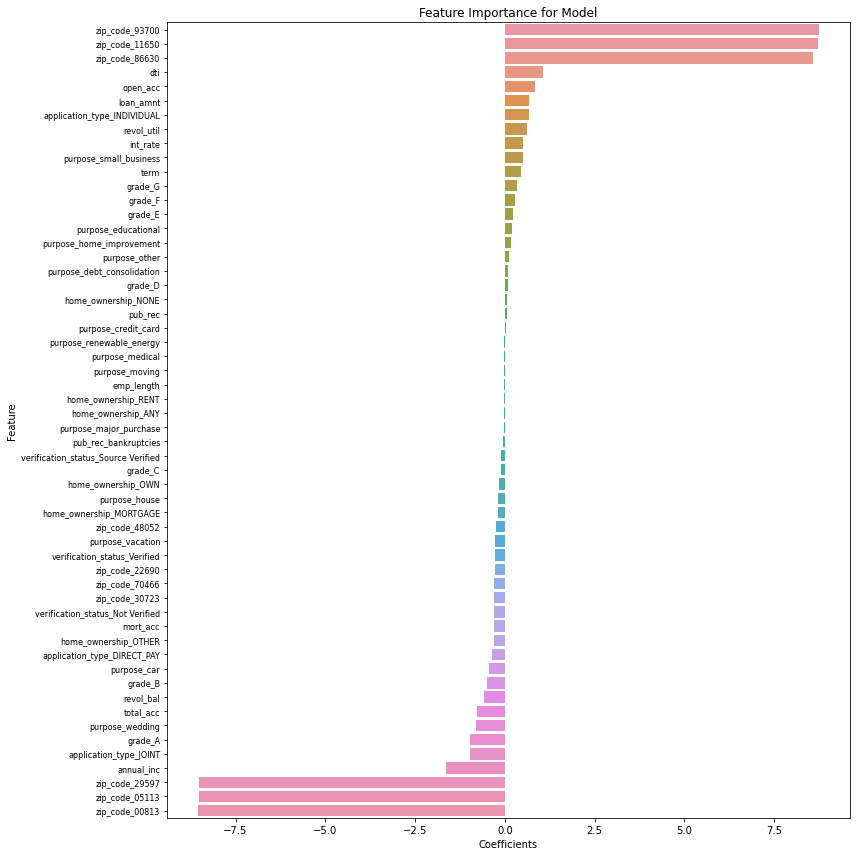

In [54]:
feature_imp = pd.DataFrame({'Columns':x_train.columns, 'Coefficients':model.coef_[0]}).round(2).sort_values('Coefficients', ascending=False)

plt.figure(figsize=(12,12))
sns.barplot(y = feature_imp['Columns'],
           x =  feature_imp['Coefficients'])
plt.title("Feature Importance for Model")
plt.yticks(fontsize=8)
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

* The model has assigned large weightage to zip_code features followed by dti, open_acc, loan_amnt
* Similarly, large negative coefficients are assigned to a few zip codes, followed by annual income and joint application type

**ROC Curve & AUC**

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model. It helps evaluate and compare different models by illustrating the trade-off between the true positive rate (TPR) and false positive rate (FPR) at various classification thresholds.

The ROC curve is created by plotting the TPR on the y-axis against the FPR on the x-axis for different threshold values.

* TPR: Also known as sensitivity or recall, is the proportion of true positive predictions out of all actual positive instances.
* FPR: Proportion of false positive predictions out of all actual negative instances.

A perfect classifier would have a TPR of 1 and an FPR of 0, resulting in a point at the top-left corner of the ROC curve. On the other hand, a random classifier would have an ROC curve following the diagonal line, as it has an equal chance of producing true positive and false positive predictions.

The area under the ROC curve (AUC) is a commonly used metric to quantify the overall performance of a classifier.   

A perfect classifier would have an AUC of 1, while a random classifier would have an AUC of 0.5. The higher the AUC value, the better the classifier's performance in distinguishing between positive and negative instances.

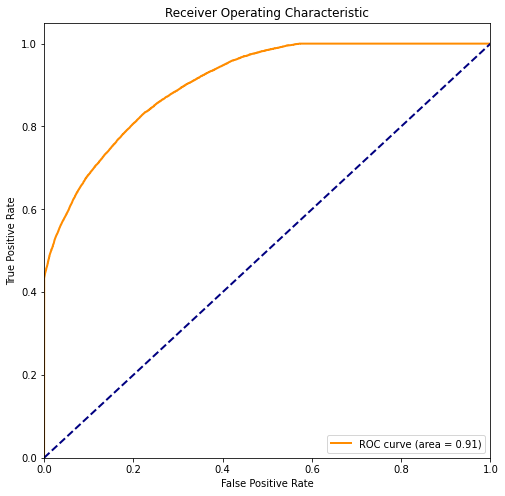

In [55]:
# Predict probabilities for the test set
probs = model.predict_proba(x_test)[:,1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

* AUC of 0.91 signifies that the model is able to discriminate well between the positive and the negative class.
* But it is not a good measure for an imbalanced target variable because it may be high even when the classifier has a poor score on the minority class.  
* This can happen when the classifier performs well on the majority class instances, which dominate the dataset. As a result, the AUC may appear high, but the model may not effectively identify the minority class instances.  

Lets plot the Precision-Recall curve which is more suited for evaluation of imbalanced data

**Precision Recall Curve**

The Precision-Recall (PR) curve is another graphical representation commonly used to evaluate the performance of a binary classification model. It provides insights into the trade-off between precision and recall at various classification thresholds.

* **Precision** represents the proportion of correctly predicted positive instances out of all instances predicted as positive. It focuses on the accuracy of positive predictions.
* **Recall**, also known as sensitivity or true positive rate, represents the proportion of correctly predicted positive instances out of all actual positive instances. It focuses on capturing all positive instances.

Similar to the ROC curve, the PR curve is created by plotting recall on the x-axis and precision on the y-axis for different threshold values. The curve illustrates the relationship between precision and recall as the classification threshold changes.

A perfect classifier would have a precision of 1 and a recall of 1, resulting in a point at the top-right corner of the PR curve. Conversely, a random classifier would have a PR curve following the horizontal line defined by the ratio of positive instances in the dataset.

The **PR curve is useful when dealing with imbalanced datasets**, where the number of negative instances far outweighs the positives. In such cases, the PR curve provides a more comprehensive evaluation of the model's performance compared to the ROC curve. This is because the ROC curve can be misleading when the majority of instances are negative, as it primarily focuses on the true negative rate.

The area under the PR curve (AUPRC) is a commonly used metric to quantify the overall performance of a classifier. A perfect classifier would have an AUPRC of 1, while a random classifier would have an AUPRC equal to the ratio of positive instances. Generally, a higher AUPRC indicates better performance.

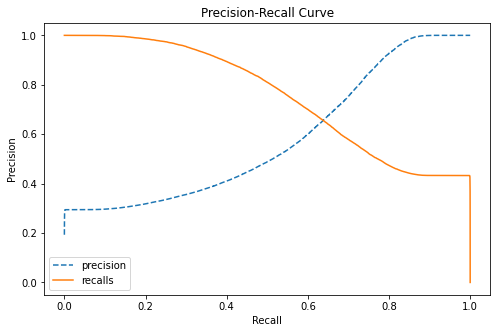

In [56]:
# Compute the false precision and recall at all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probs)

threshold_boundary = thresholds.shape[0]
plt.figure(figsize=(8,5))
#plot precision
plt.plot(thresholds,precision[0:threshold_boundary],linestyle='--',label='precision')
#plot recall
plt.plot(thresholds,recall[0:threshold_boundary],label='recalls')

# start,end=plt.xlim()
# plt.xticks(np.round(np.arange(start,end,0.1),2))

# Area under Precision Recall Curve
auprc = average_precision_score(y_test, probs)

# Plot the precision-recall curve
#plt.plot(recall, precision, marker='.', label='PR curve (area = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
#plt.grid()
plt.show()

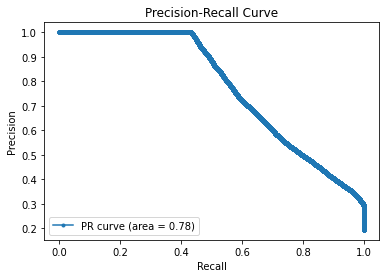

In [57]:
# Compute the false precision and recall at all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Area under Precision Recall Curve
auprc = average_precision_score(y_test, probs)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.', label='PR curve (area = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

As expected, the area under precision recall curve is not as high. It is a decent model as the area is more than 0.5 (random model benchmark) but there is still scope for improvement

## Conclusion

**Q1.** How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.  
**Ans:** Precision score is an indicator of type1 error. Increasing precision score of the model will minimise false positives and ensure that the company is not losing out on the opportunity to finance worthy individuals.

**Q2.** Since NPA (non-performing asset) is a real problem in this industry, it's important we play safe and shouldn't disburse loans to anyone.  
**Ans:** Recall score is an indicator of how many actual defaulters are flagged by the model. By increasing the recall score, we can minimise false negatives (type2 error) and ensure that loans are not disbursed to defaulters.

**Insights**

1) Impact of Categorical Attributes on loan_status (target variable):
* The % of defaulters is much higher for longer (60-month) term
* As expected, grade/sub-grade has the maximum impact on loan_status with highest grade having maximum defaulters
* Zip codes such as 11650, 86630 and 93700 have 100% defaulters
* We can remove initial_list_status and state as they have no impact on loan_status
* Direct pay application type has higher default rate compared to individual/joint
* Loan taken for the purpose of small business has the highest rate of default

2) Impact of Numerical Attributes on loan_status (target variable):
* It can be observed that the mean loan_amnt, int_rate, dti, open_acc and revol_util are higher for defaulters
* The mean annual income is lower for defaulters

3) A Logistic Regression model (trained after upsampling the data to balance the target variable) performed well, rendering accuracy of 80%.
4) The model had a precision score of 95%, recall score of 80%, and f1 score of 87% on the negative class
5) The model had a precision score of 49%, recall score of 81%, and f1 score of 61% on the positive class
6) The ROC plot shows that the area under ROC curve is 0.91, which signifies that the model is able to differentiate well between both classes
7) The area under Precision Recall curve is 0.78 (can be improved using hyperparameter tuning/increasing model complexity)


**Recommendations**
* The optimal strategy to achieve the objective of balancing the risk of increasing NPAs by disbursing loans to defaulters with the opportunity to earn interest by disbursing loans to as many worthy customers as possible: maximise the F1 score along with the area under Precision Recall Curve (precision-recall trade-off)
* More complex classifiers like random forest would give better results compared to logistic regression because they are not restricted by the linearity of decision boundary